# Multiple Linear Regression, Subset Selection, Cross Validation

---


### INSTRUCTIONS

- To submit your assignment follow the instructions given in canvas.
- Restart the kernel and run the whole notebook again before you submit. 
- Do not include your name(s) in the notebook if you are submitting as a group. 
- If you submit individually and you have worked with someone, please include the name of your [one] partner below. 

---

Import libraries:

In [1]:
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score
import statsmodels as sm
from statsmodels.regression.linear_model import OLS
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.linear_model import RidgeCV
from sklearn.linear_model import LassoCV
%matplotlib inline
import sys
import seaborn as sns
sns.set_context('notebook')
sns.set_style('whitegrid')

# Forecasting Bike Sharing Usage

In this homework, we will focus on multiple linear regression and will explore techniques for subset selection. The specific task is to build a regression model for a bike share system that can predict the total number of bike rentals in a given day, based on attributes about the day. Such a demand forecasting model would be useful in planning the number of bikes that need to be available in the system on any given day, and also in monitoring traffic in the city. The data for this problem was collected from the Capital Bikeshare program in Washington D.C. over two years.   

The data set is provided in the files `Bikeshare_train.csv` and `Bikeshare_test.csv`, as separate training and test sets. Each row in these files contains 10 attributes describing a day and its weather:
- season (1 = spring, 2 = summer, 3 = fall, 4 = winter)
- month (1 through 12, with 1 denoting Jan)
- holiday (1 = the day is a holiday, 0 = otherwise)
- day_of_week (0 through 6, with 0 denoting Sunday)
- workingday (1 = the day is neither a holiday or weekend, 0 = otherwise)
- weather 
    - 1: Clear, Few clouds, Partly cloudy, Partly cloudy
    - 2: Mist + Cloudy, Mist + Broken clouds, Mist + Few clouds, Mist
    - 3: Light Snow, Light Rain + Thunderstorm + Scattered clouds, Light Rain + Scattered clouds
    - 4: Heavy Rain + Ice Pallets + Thunderstorm + Mist, Snow + Fog 
- temp (temperature in Celsius)
- atemp (apparent temperature, or relative outdoor temperature, in Celsius)
- humidity (relative humidity)
- windspeed (wind speed)

and the last column 'count' contains the response variable, i.e. total number of bike rentals on the day.


## Part (a): Data Exploration & Preprocessing

As a first step, identify important characteristics of the data using suitable visualizations when necessary. Some of the questions you may ask include (but are not limited to):

- How does the number of bike rentals vary between weekdays and weekends? 
- How about bike rentals on holidays?
- What effect does the season have on the bike rentals on a given day?
- Is the number of bike rentals lower than average when there is rain or snow?
- How does temperature effect bike rentals?
- Do any of the numeric attributes have a clear non-linear dependence with number of the bike rentals?



In [2]:
train_df = pd.read_csv('Bikeshare_train.csv')
test_df = pd.read_csv('Bikeshare_test.csv')
train_df.drop('Unnamed: 0',axis=1,inplace=True)
test_df.drop('Unnamed: 0',axis=1,inplace=True)
train_df.head()

season  month  holiday  day_of_week  workingday  weather  temp  atemp  \
0     2.0    5.0      0.0          2.0         1.0      2.0  24.0   26.0   
1     4.0   12.0      0.0          2.0         1.0      1.0  15.0   19.0   
2     2.0    6.0      0.0          4.0         1.0      1.0  26.0   28.0   
3     4.0   12.0      0.0          0.0         0.0      1.0   0.0    4.0   
4     3.0    9.0      0.0          3.0         1.0      3.0  23.0   23.0   

   humidity  windspeed   count  
0   76.5833   0.118167  6073.0  
1   73.3750   0.174129  6606.0  
2   56.9583   0.253733  7363.0  
3   58.6250   0.169779  2431.0  
4   91.7083   0.097021  1996.0

Text(0,0.5,'Frequency')

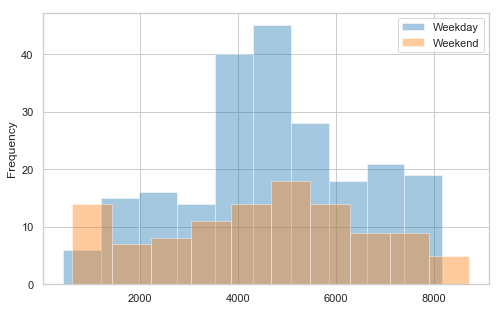

In [3]:
## How does the number of bike rentals vary between weekdays and weekends?
plt.figure(figsize=(8,5))
weekday = train_df[train_df.workingday == 1]
weekend = train_df[train_df.workingday == 0]
plt.hist(weekday['count'],bins = 10,alpha = 0.4,label='Weekday')
plt.hist(weekend['count'],bins = 10,alpha = 0.4,label='Weekend')
plt.legend(loc = 'best')
plt.ylabel('Frequency')

Text(0,0.5,'Frequency')

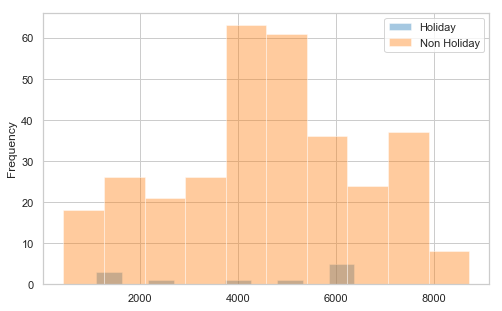

In [4]:
## How about bike rentals on holidays?
plt.figure(figsize=(8,5))
holiday = train_df[train_df.holiday == 1]
nonholiday = train_df[train_df.holiday == 0]
plt.hist(holiday['count'],bins = 10,alpha = 0.4,label='Holiday')
plt.hist(nonholiday['count'],bins = 10,alpha = 0.4,label='Non Holiday')
plt.legend(loc = 'best')
plt.ylabel('Frequency')

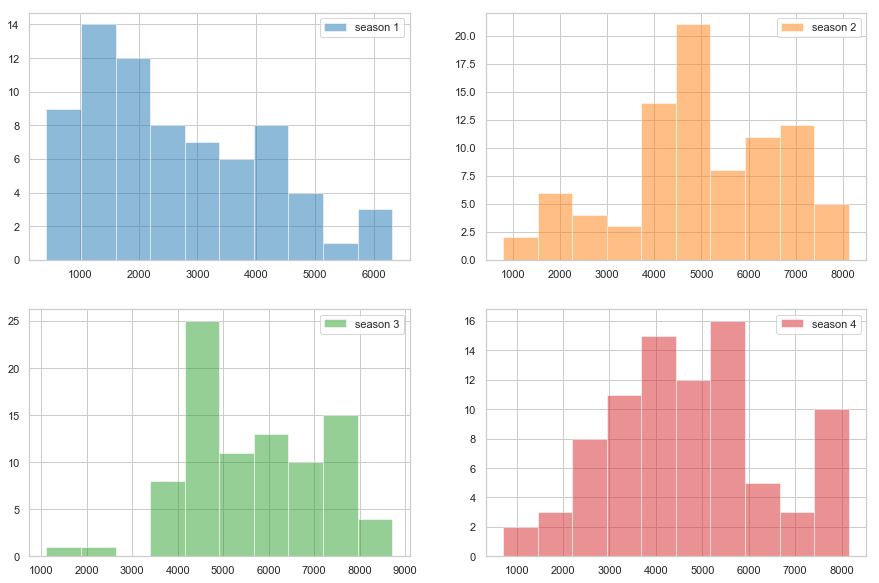

In [5]:
## What effect does the season have on the bike rentals on a given day?
seasons = train_df.season.value_counts()
fig,ax = plt.subplots(2,2,figsize = (15,10))
ax = ax.ravel()
for season in range(len(seasons)):
    season_df = train_df[train_df.season == season+1]
    ax[season].hist(season_df['count'],alpha = 0.5,label = 'season '+str(int(season+1)),color = sns.color_palette()[season])
    ax[season].set_ylabel = 'Frequency'
    ax[season].legend(loc = 'best')

Text(0,0.5,'Frequency')

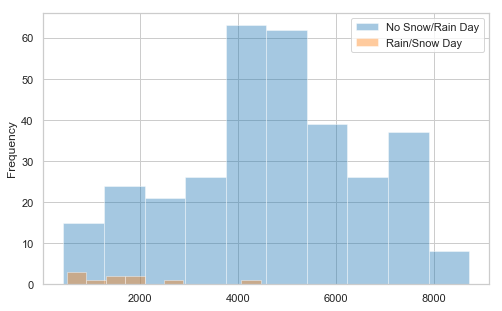

In [6]:
### Is the number of bike rentals lower than average when there is rain or snow?
plt.figure(figsize=(8,5))
no_rain_snow = train_df[train_df.weather <= 2]
rain_snow = train_df[train_df.weather >= 3]
plt.hist(no_rain_snow['count'],bins = 10,alpha = 0.4,label='No Snow/Rain Day')
plt.hist(rain_snow['count'],bins = 10,alpha = 0.4,label='Rain/Snow Day')
plt.legend(loc = 'best')
plt.ylabel('Frequency')

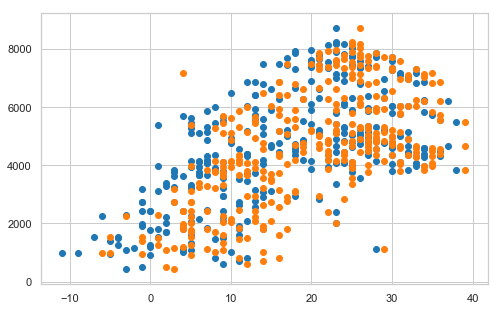

In [7]:
## How does temperature effect bike rentals?
plt.figure(figsize=(8,5))
plt.scatter(train_df['temp'],train_df['count'])
plt.scatter(train_df['atemp'],train_df['count'])

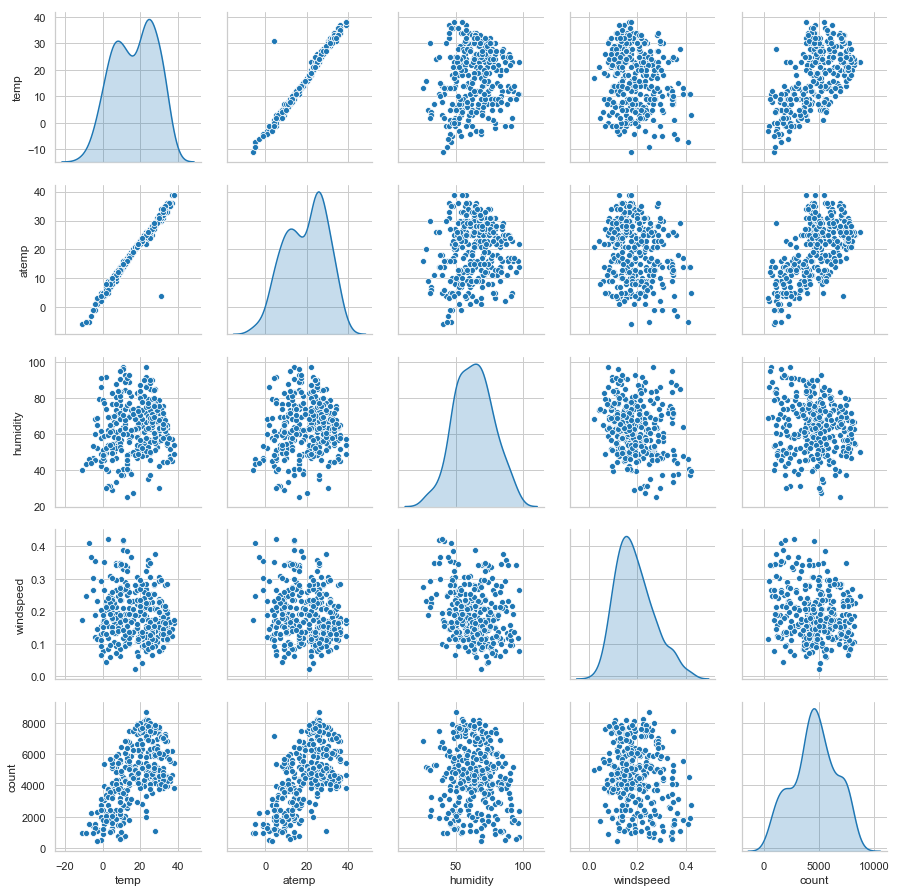

In [8]:
## Do any of the numeric attributes have a clear non-linear dependence with number of the bike rentals?
sns.pairplot(train_df[['temp', 'atemp', 'humidity', 'windspeed', 'count']],diag_kind='kde')

We next require you to pre-process the categorical and numerical attributes in the data set:

- Notice that this data set contains categorical attributes with two or more categories. **Why can't they be directly used as predictors?** Convert these categorical attributes into multiple binary attributes using one-hot encoding: in the place of every categorical attribute $x_j$ that has categories $1, \ldots, K_j$, introduce $K_j-1$ binary predictors $x_{j1}, \ldots, x_{j,K_j-1}$ where $x_{jk}$ is 1 whenever $x_j = k$ and 0 otherwise. 
** Why is it okay to not have a binary column for the $K_j$-th category? **

- Since the attributes are in different scales, it is a good practice to standardize the continuous predictors, i.e. to scale each continuous predictor to have zero mean and a standard deviation of 1. This can be done by applying the following transform to each continuous-valued predictor $j$:
$\hat{x}_{ij} = (x_{ij} - \bar{x}_j) / s_j$, where $\bar{x}_j$ and $s_j$ are the sample mean and sample standard deviation (SD) of predictor $j$ in the training set. We emphasize that the mean and SD values used for standardization must be estimated using only the training set observations, while the transform is applied to both the training and test sets. 
** Why shouldn't we include the test set observations in computing the mean and SD? **

- Provide a table of the summary statistics of the new attributes (`pd.describe()' function will help).

*Hint:* You may use the `pd.get_dummies` function to convert a categorical attribute in a data frame to one-hot encoding. This function creates $K$ binary columns for an attribute with $K$ categories. We suggest that you delete the last (or first) binary column generated by this function.

**Note:** We shall use the term "attribute" to refer to a categorical column in the data set, and the term "predictor" to refer to the individual binary columns resulting out of one-hot encoding.

In [9]:
train_df.describe()

season       month     holiday  day_of_week  workingday  \
count  331.000000  331.000000  331.000000   331.000000  331.000000   
mean     2.561934    6.640483    0.033233     2.854985    0.670695   
std      1.094726    3.353974    0.179515     2.048680    0.470672   
min      1.000000    1.000000    0.000000     0.000000    0.000000   
25%      2.000000    4.000000    0.000000     1.000000    0.000000   
50%      3.000000    7.000000    0.000000     3.000000    1.000000   
75%      4.000000    9.500000    0.000000     5.000000    1.000000   
max      4.000000   12.000000    1.000000     6.000000    1.000000   

          weather        temp       atemp    humidity   windspeed        count  
count  331.000000  331.000000  331.000000  331.000000  331.000000   331.000000  
mean     1.389728   17.018127   19.543807   63.385776    0.190833  4598.447130  
std      0.546962   11.192515    9.930991   14.334789    0.078240  1935.319338  
min      1.000000  -11.000000   -6.000000   25.416700    0.022392   431.000000  
25%      1.000000    7.500000   11.000000   52.702900    0.133083  3370.000000  
50%      1.000000   18.000000   21.000000   63.291700    0.178479  4648.000000  
75%      2.000000   26.000000   27.000000   73.500000    0.235380  5981.000000  
max      3.000000   38.000000   39.000000   97.250000    0.421642  8714.000000

In [10]:
categorical_columns = ['season', 'month', 'holiday', 'day_of_week', 'workingday', 'weather']
categorical_columns_g2cols = ['season', 'month', 'day_of_week', 'weather']
numerical_columns = ['temp', 'atemp', 'humidity', 'windspeed']

In [11]:
train_df = pd.get_dummies(train_df,columns=categorical_columns_g2cols,drop_first=True)
test_df = pd.get_dummies(test_df,columns=categorical_columns_g2cols,drop_first=True)

In [12]:
train_df.columns

Index(['holiday', 'workingday', 'temp', 'atemp', 'humidity', 'windspeed',
       'count', 'season_2.0', 'season_3.0', 'season_4.0', 'month_2.0',
       'month_3.0', 'month_4.0', 'month_5.0', 'month_6.0', 'month_7.0',
       'month_8.0', 'month_9.0', 'month_10.0', 'month_11.0', 'month_12.0',
       'day_of_week_1.0', 'day_of_week_2.0', 'day_of_week_3.0',
       'day_of_week_4.0', 'day_of_week_5.0', 'day_of_week_6.0', 'weather_2.0',
       'weather_3.0'],
      dtype='object')

In [13]:
mean = train_df[numerical_columns].mean()
std = train_df[numerical_columns].std()

train_df[numerical_columns] = (train_df[numerical_columns] - mean)/std
test_df[numerical_columns] = (test_df[numerical_columns] - mean)/std

In [14]:
train_df.describe()

holiday  workingday          temp         atemp      humidity  \
count  331.000000  331.000000  3.310000e+02  3.310000e+02  3.310000e+02   
mean     0.033233    0.670695 -6.976628e-17 -1.227618e-16 -7.808457e-16   
std      0.179515    0.470672  1.000000e+00  1.000000e+00  1.000000e+00   
min      0.000000    0.000000 -2.503291e+00 -2.572131e+00 -2.648736e+00   
25%      0.000000    0.000000 -8.504011e-01 -8.603176e-01 -7.452412e-01   
50%      0.000000    1.000000  8.772587e-02  1.466312e-01 -6.562743e-03   
75%      0.000000    1.000000  8.024892e-01  7.508005e-01  7.055719e-01   
max      1.000000    1.000000  1.874634e+00  1.959139e+00  2.362380e+00   

          windspeed        count  season_2.0  season_3.0  season_4.0  \
count  3.310000e+02   331.000000  331.000000  331.000000  331.000000   
mean   1.543579e-15  4598.447130    0.259819    0.265861    0.256798   
std    1.000000e+00  1935.319338    0.439199    0.442459    0.437528   
min   -2.152869e+00   431.000000    0.000000    0.000000    0.000000   
25%   -7.381149e-01  3370.000000    0.000000    0.000000    0.000000   
50%   -1.579037e-01  4648.000000    0.000000    0.000000    0.000000   
75%    5.693478e-01  5981.000000    1.000000    1.000000    1.000000   
max    2.949989e+00  8714.000000    1.000000    1.000000    1.000000   

          ...       month_11.0  month_12.0  day_of_week_1.0  day_of_week_2.0  \
count     ...       331.000000  331.000000       331.000000       331.000000   
mean      ...         0.093656    0.066465         0.175227         0.135952   
std       ...         0.291790    0.249471         0.380736         0.343256   
min       ...         0.000000    0.000000         0.000000         0.000000   
25%       ...         0.000000    0.000000         0.000000         0.000000   
50%       ...         0.000000    0.000000         0.000000         0.000000   
75%       ...         0.000000    0.000000         0.000000         0.000000   
max       ...         1.000000    1.000000         1.000000         1.000000   

       day_of_week_3.0  day_of_week_4.0  day_of_week_5.0  day_of_week_6.0  \
count       331.000000       331.000000       331.000000       331.000000   
mean          0.123867         0.123867         0.145015         0.135952   
std           0.329929         0.329929         0.352649         0.343256   
min           0.000000         0.000000         0.000000         0.000000   
25%           0.000000         0.000000         0.000000         0.000000   
50%           0.000000         0.000000         0.000000         0.000000   
75%           0.000000         0.000000         0.000000         0.000000   
max           1.000000         1.000000         1.000000         1.000000   

       weather_2.0  weather_3.0  
count   331.000000   331.000000  
mean      0.329305     0.030211  
std       0.470672     0.171428  
min       0.000000     0.000000  
25%       0.000000     0.000000  
50%       0.000000     0.000000  
75%       1.000000     0.000000  
max       1.000000     1.000000  

[8 rows x 29 columns]

your answers here

## Part (b): Multiple Linear Regression

We are now ready to fit a linear regression model and analyze its coefficients and residuals.

- Fit a multiple linear regression model to the training set, and report its $R^2$ score on the test set.
- *Statistical significance*: Using a t-test, find out which of estimated coefficients are statistically significant at a significance level of 5% (p-value<0.05). Based on the results of the test, answer the following questions:
    - Which among the predictors have a positive correlation with the number of bike rentals? 
    - Does the day of a week have a relationship with bike rentals? 
    - Does the month influence the bike rentals? 
    - What effect does a holiday have on  bike rentals? 
    - Is there a difference in the coefficients assigned to `temp` and `atemp`? Give an explanation for your observation.
- *Residual plot:* Make a plot of residuals of the fitted model ${e} = y - \hat{y}$ as a function of the predicted value $\hat{y}$. Note that this is different from the residual plot for simple linear regression. Draw a horizontal line denoting the zero residual value on the Y-axis. Does the plot reveal a non-linear relationship between the predictors and response? What does the plot convey about the variance of the error terms?


In [21]:
from statsmodels.regression.linear_model import OLS
from statsmodels.tools.tools import add_constant
X_train = add_constant(train_df.drop('count',axis = 1))
X_test = add_constant(test_df.drop('count',axis=1))
y_train = train_df['count']
y_test = test_df['count']

In [22]:
model = OLS(y_train.values.reshape(-1,1),X_train)
results = model.fit()

In [29]:
y_hat_train = results.predict(X_train)
y_hat_test = results.predict(X_test)

print('The Train R2 :',r2_score(y_train,y_hat_train))
print('The Test R2 :',r2_score(y_test,y_hat_test))

The Train R2 : 0.5761281783129482
The Test R2 : 0.2493421114652754


In [30]:
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.576
Model:                            OLS   Adj. R-squared:                  0.538
Method:                 Least Squares   F-statistic:                     15.25
Date:                Sat, 17 Aug 2019   Prob (F-statistic):           6.56e-42
Time:                        11:37:31   Log-Likelihood:                -2832.1
No. Observations:                 331   AIC:                             5720.
Df Residuals:                     303   BIC:                             5827.
Df Model:                          27                                         
Covariance Type:            nonrobust                                         
===================================================================================
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
const            3681.7765    433.655      8.490      0.000    2828.419    4535.134
holiday          -284.3563    398.982     -0.713      0.477   -1069.483     500.770
workingday        308.1531    165.413      1.863      0.063     -17.351     633.657
temp              925.7338    474.536      1.951      0.052      -8.070    1859.538
atemp             312.4341    429.987      0.727      0.468    -533.705    1158.573
humidity         -548.4929    113.200     -4.845      0.000    -771.251    -325.735
windspeed        -255.1226     80.766     -3.159      0.002    -414.057     -96.189
season_2.0        898.8290    487.802      1.843      0.066     -61.079    1858.737
season_3.0       1032.8816    567.827      1.819      0.070     -84.503    2150.266
season_4.0       1226.1865    506.763      2.420      0.016     228.966    2223.407
month_2.0          88.9401    397.048      0.224      0.823    -692.381     870.262
month_3.0         239.1809    446.873      0.535      0.593    -640.188    1118.549
month_4.0         333.3491    675.444      0.494      0.622    -995.806    1662.504
month_5.0         -65.8125    726.311     -0.091      0.928   -1495.065    1363.440
month_6.0        -792.2629    749.803     -1.057      0.292   -2267.744     683.218
month_7.0       -1279.9870    816.047     -1.569      0.118   -2885.824     325.850
month_8.0        -776.4755    794.782     -0.977      0.329   -2340.467     787.516
month_9.0         405.1446    694.714      0.583      0.560    -961.931    1772.220
month_10.0        486.2509    651.713      0.746      0.456    -796.206    1768.708
month_11.0        112.6816    621.610      0.181      0.856   -1110.538    1335.902
month_12.0       -118.8358    505.353     -0.235      0.814   -1113.282     875.611
day_of_week_1.0  -123.7515    170.981     -0.724      0.470    -460.212     212.709
day_of_week_2.0  -195.2859    203.703     -0.959      0.338    -596.137     205.565
day_of_week_3.0   170.5113    213.789      0.798      0.426    -250.187     591.210
day_of_week_4.0    61.2560    206.213      0.297      0.767    -344.536     467.048
day_of_week_5.0   111.0669    198.877      0.558      0.577    -280.288     502.422
day_of_week_6.0   465.1450    269.154      1.728      0.085     -64.504     994.794
weather_2.0       -16.5666    210.139     -0.079      0.937    -430.083     396.949
weather_3.0     -1581.9783    529.223     -2.989      0.003   -2623.396    -540.560
==============================================================================
Omnibus:                       28.947   Durbin-Watson:                   1.912
Prob(Omnibus):                  0.000   Jarque-Bera (JB):                9.753
Skew:                           0.054   Prob(JB):                      0.00762
Kurtosis:                       2.166   Cond. No.                     1.37e+16


In [32]:
results.pvalues[((results.pvalues < 0.05) & (results.params > 0))]

const         9.368885e-16
season_4.0    1.612408e-02
dtype: float64

## Part (c): Checking Collinearity

Does the data suffer from multi-collinearity? To answer this question, let us first analyze the correlation matrix for the data. Compute the (Pearson product-moment) correlation matrix for the predictor variables in the training set, and visualize the matrix using a heatmap. For categorical attributes, you should use each binary predictor resulting from one-hot encoding to compute their correlations.  Are there predictors that fall into natural groups based on the correlation values? 

*Hint:* You may use the `np.corrcoef` function to compute the correlation matrix for a data set (do not forget to transpose the data matrix). You may use `plt.pcolor` function to visualize the correlation matrix.

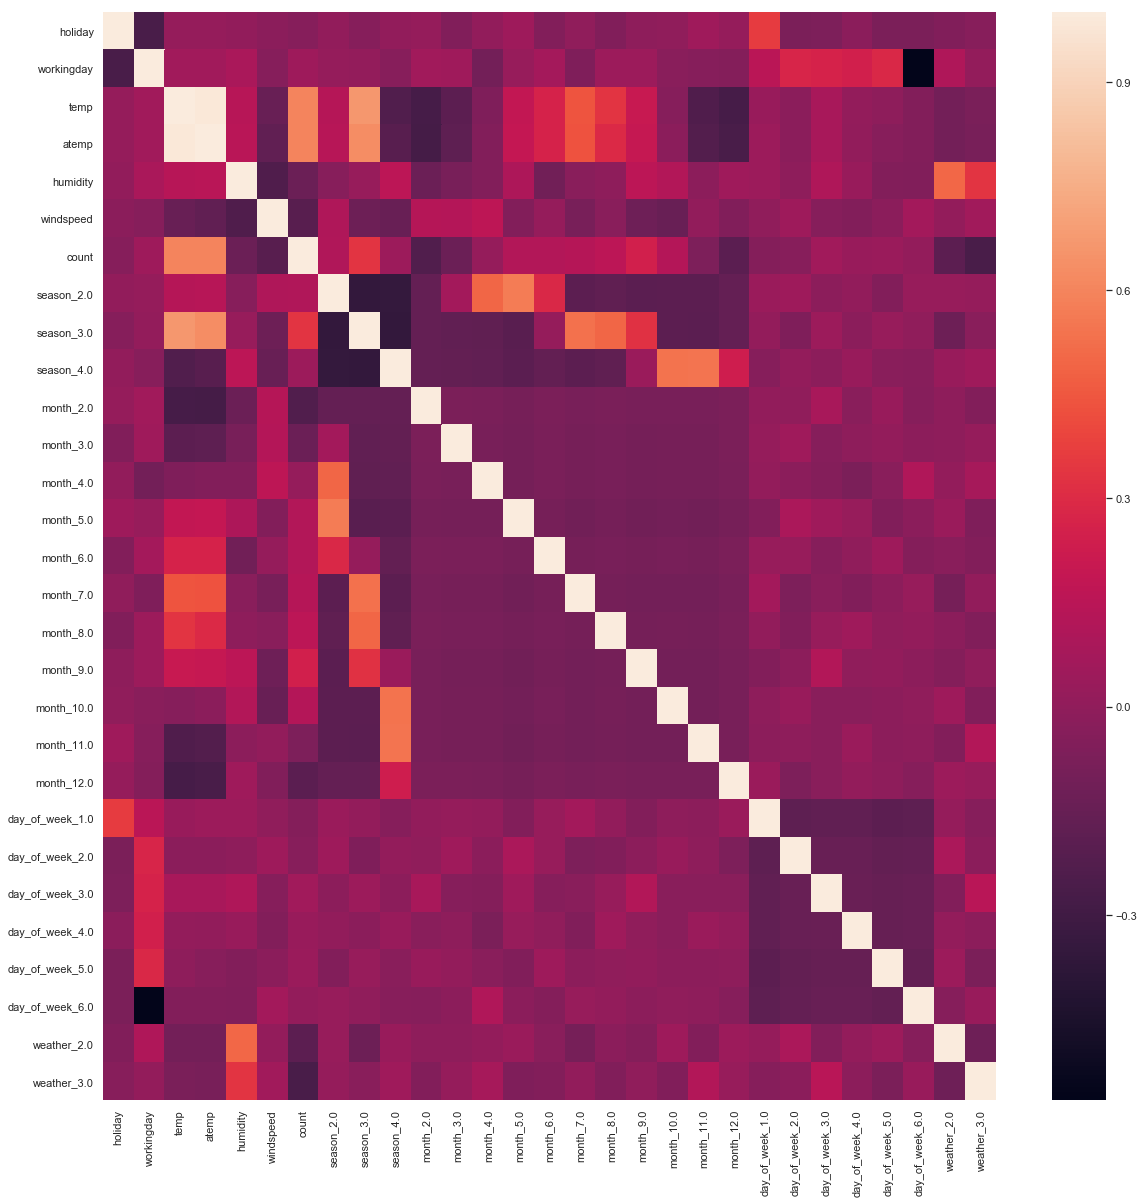

In [43]:
plt.figure(figsize=(20,20))
sns.heatmap(train_df.corr())

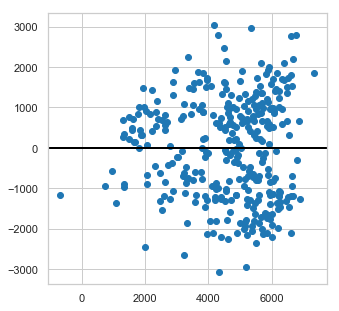

In [60]:
plt.figure(figsize=(5,5))
plt.scatter(y_hat_train, y_hat_train - y_train)
plt.axhline(0, c='black', lw=2)

(array([ 4., 21., 40., 57., 35., 45., 69., 40., 14.,  6.]),
 array([-3076.47515852, -2464.02663933, -1851.57812015, -1239.12960096,
         -626.68108178,   -14.23256259,   598.21595659,  1210.66447578,
         1823.11299496,  2435.56151415,  3048.01003333]),
 <a list of 10 Patch objects>)

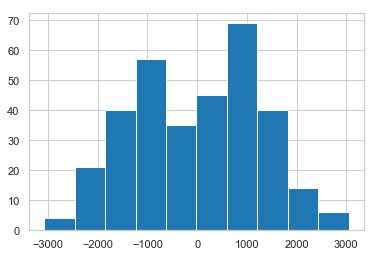

In [58]:
plt.hist(y_hat_train - y_train)

your answers here

## Part (d): Subset Selection

Apply either one of the following subset selection methods discussed in class to choose a minimal subset of predictors that are related to the response variable:
- Step-wise forward selection
- Step-wise backward selection

We require you to implement both these methods *from scratch*. You may use the Bayesian Information Criterion (BIC) to choose the subset size in each method. Do these methods eliminate one or more of the redundant predictors (if any) identified in Part (c)? In each case, fit linear regression models using the identified subset of predictors to the training set. How do the test $R^2$ scores for the fitted models compare with the model fitted in Part (b) using all predictors?




In [17]:
# your code here

your answers here

## Part (e): Cross Validation

- Perform a 10-fold cross-validation procedure to select between the 3 competing models you have so far: the model with the best BIC from Step-wise forward selection, the model with the best BIC from Step-wise backward selection (if it is different), and the model with all possible predictors.  Report the average $R^2$ across all 10 validation sets for each model and compare the results.  Why do you think this is the case?
- Evaluate each of the 3 models on the provided left out test set by calculating $R^2$.  Do the results agree with the cross-validation?  Why or why not?

In [18]:
# your code here

your answers here